In [1]:
import os
os.chdir("../")

In [2]:
import sys
sys.path.insert(0, 'C:\\\\Users\\\\marce\\\\Desktop\\\\_tfg\\\\yolov7\\')

In [3]:
print(os.getcwd())
sys.path

c:\Users\marce\Desktop\_tfg\smear-beta


['C:\\\\Users\\\\marce\\\\Desktop\\\\_tfg\\\\yolov7\\',
 'c:\\Users\\marce\\Desktop\\_tfg\\smear-beta\\prototype',
 'c:\\Users\\marce\\miniconda3\\envs\\tfg2\\python39.zip',
 'c:\\Users\\marce\\miniconda3\\envs\\tfg2\\DLLs',
 'c:\\Users\\marce\\miniconda3\\envs\\tfg2\\lib',
 'c:\\Users\\marce\\miniconda3\\envs\\tfg2',
 '',
 'C:\\Users\\marce\\AppData\\Roaming\\Python\\Python39\\site-packages',
 'C:\\Users\\marce\\AppData\\Roaming\\Python\\Python39\\site-packages\\natsort-8.2.0-py3.9.egg',
 'c:\\Users\\marce\\miniconda3\\envs\\tfg2\\lib\\site-packages',
 'c:\\users\\marce\\desktop\\_tfg\\detectron2',
 'c:\\Users\\marce\\miniconda3\\envs\\tfg2\\lib\\site-packages\\win32',
 'c:\\Users\\marce\\miniconda3\\envs\\tfg2\\lib\\site-packages\\win32\\lib',
 'c:\\Users\\marce\\miniconda3\\envs\\tfg2\\lib\\site-packages\\Pythonwin']

In [4]:
import matplotlib.pyplot as plt
import torch
import cv2
import math
import numpy as np
from scipy.signal import savgol_filter

from torchvision import transforms

from src.smear_beta_utils.config import load_config
from src.smear_beta_utils.yolo_utils import letterbox
from src.smear_beta_utils.yolo_utils import non_max_suppression_kpt
from src.smear_beta_utils.yolo_utils import output_to_keypoint, plot_skeleton_kpts

In [5]:
global_config, local_config = load_config()

In [6]:
local_config['PATH']['yolov7_pose_estimation_models']+"yolov7-w6-pose.pt"

'C:\\Users\\marce\\Desktop\\_tfg\\smear-beta\\models\\pose_estimation\\yolov7yolov7-w6-pose.pt'

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device used to run: {device}")
weigths = torch.load(
    local_config['PATH']['yolov7_pose_estimation_models']+
    "\\yolov7-w6-pose.pt"
)


model = weigths['model']
model = model.half().to(device)
_ = model.eval()

Device used to run: cuda:0


In [8]:
body_parts = {
    "left_hand": {
        "index": 34,
        "positions": []
    },
    "right_hand": {
        "index": 37,
        "positions": []
    },
    "left_foot": {
        "index": 52,
        "positions": []
    },
    "right_foot": {
        "index": 55,
        "positions": []
    },
    "left_knee": {
        "index": 28,
    }
}

In [17]:
os.chdir("../smear-beta/")
video_path = local_config['PATH']['raw_videos']+"\\pose_estimation_2_short.mp4"

cap = cv2.VideoCapture(video_path)
if (cap.isOpened() == False):
    print('Video could not be read')
 
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))


scale_by = (
    frame_width if frame_width > frame_height
    else frame_height
)
scale_factor = 3
 
# Pass the first frame through `letterbox` function to get the resized image,
# to be used for `VideoWriter` dimensions. Resize by larger side.
vid_write_image = letterbox(cap.read()[1], int(scale_by/scale_factor), stride=64, auto=True)[0]
resize_height, resize_width = vid_write_image.shape[:2]

print(resize_height)
print(resize_width)
 
save_name = local_config['PATH']['output_videos']+"yolov7_vidal_test.mp4"

# Define codec and create VideoWriter object .
out = cv2.VideoWriter(
    save_name,
    cv2.VideoWriter_fourcc(*'mp4v'), 
    30,
    (resize_width, resize_height)
)

640
384


In [18]:
frames = []
foot_distance_treshold = 0
foot_distance_set = False


while(cap.isOpened):

    ret, frame = cap.read()
  
    if ret:
        orig_image = frame
        image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB)
        image = letterbox(image, int(scale_by/scale_factor), stride=64, auto=True)[0]
        image_ = image.copy()
        image = transforms.ToTensor()(image)
        image = torch.tensor(np.array([image.numpy()]))
        image = image.to(device)
        image = image.half()
    

        with torch.no_grad():
            output, _ = model(image)
            
        output = non_max_suppression_kpt(output, 0.25, 0.65, nc=model.yaml['nc'], nkpt=model.yaml['nkpt'], kpt_label=True)
        output = output_to_keypoint(output)
        nimg = image[0].permute(1, 2, 0) * 255
        nimg = nimg.cpu().numpy().astype(np.uint8)
        nimg = cv2.cvtColor(nimg, cv2.COLOR_RGB2BGR)
        
        body_parts["left_hand"]["positions"].append(
            (output[0, body_parts["left_hand"]["index"]], 
             output[0, body_parts["left_hand"]["index"]+1])
        )
        
        body_parts["right_hand"]["positions"].append(
            (output[0, body_parts["right_hand"]["index"]], 
             output[0, body_parts["right_hand"]["index"]+1])
        )
        
        body_parts["left_foot"]["positions"].append(
            (output[0, body_parts["left_foot"]["index"]], 
             output[0, body_parts["left_foot"]["index"]+1])
        )
        
        body_parts["right_foot"]["positions"].append(
            (output[0, body_parts["right_foot"]["index"]], 
             output[0, body_parts["right_foot"]["index"]+1])
        )
        
        if not foot_distance_set:
            left_foot_confidence = output[0, body_parts["left_foot"]["index"]+2]
            left_knee_confidence = output[0, body_parts["left_knee"]["index"]+2]
            if (
                left_foot_confidence>0.75 and
                left_knee_confidence>0.75
            ):
                foot_distance_treshold = math.sqrt(
                    (output[0, body_parts["left_hand"]["index"]] - 
                    output[0, body_parts["left_knee"]["index"]]) ** 2 
                    + 
                    (output[0, body_parts["left_hand"]["index"]+1] - 
                    output[0, body_parts["left_knee"]["index"]]+1) ** 2
                ) / 2
                
                foot_distance_set = True
            
        
        output = np.concatenate((
            output[0, 46:49],
            np.concatenate((output[0, 34:40],output[0, 52:58]))
        ))
        plot_skeleton_kpts(nimg, output.T, 3)
        
        frames.append(nimg)
        
        out.write(nimg)
        
        # Press `q` to exit.
        cv2.imshow('frame', nimg)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        # No more frames to read
        break
  

# Release VideoCapture().
cap.release()
out.release()
# Close all frames and video windows.
cv2.destroyAllWindows()

In [32]:
limb = "right_hand"

positions = np.array(body_parts[limb]["positions"])
diffs = np.diff(positions, axis=0)
distances = np.sqrt(np.sum(diffs**2, axis=1))
smoothed_distances = savgol_filter(distances, 5, 2)

smooth_mean = np.mean(smoothed_distances)
flat_indices = np.where(smoothed_distances < smooth_mean)[0]
groups = np.split(flat_indices, np.where(np.diff(flat_indices) != 1)[0]+1)
flat_zones = [(group[0], group[-1]) for group in groups]
centers = [(start_index + end_index) // 2 for start_index, end_index in flat_zones]

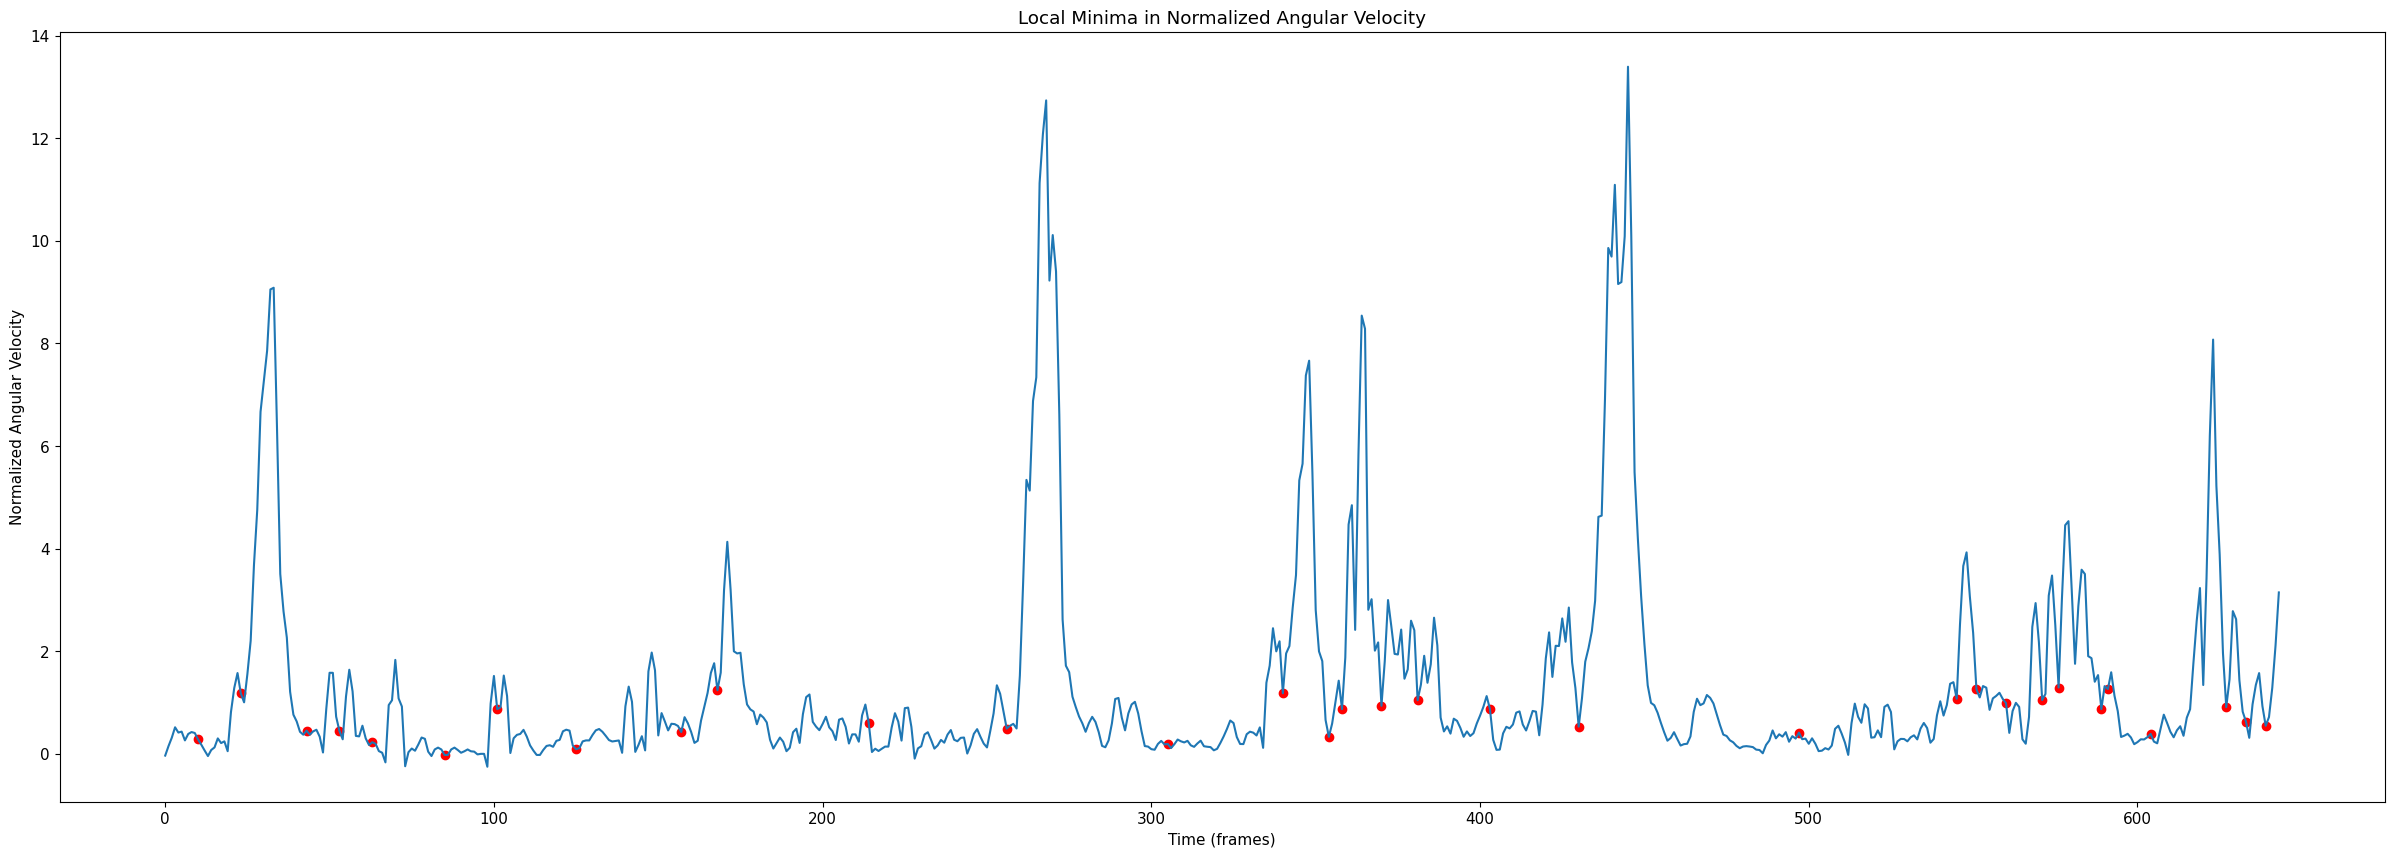

In [33]:
# Find local minima in normalized_angular_velocities
%matplotlib inline

# Plot the data and local minima
figure = plt.figure(figsize=(30, 10))
plt.plot(smoothed_distances)
plt.scatter(centers, smoothed_distances[centers], color='red')
plt.xlabel('Time (frames)')
plt.ylabel('Normalized Angular Velocity')
plt.title('Local Minima in Normalized Angular Velocity')
plt.show()

In [35]:
for frame in [frames[c] for c in centers]:
    cv2.imshow('frame', frame)
    if cv2.waitKey(300) & 0xFF == ord('q'):
        break
cv2.destroyAllWindows()